In this notebook, we will play with the models.

In [1]:
from torchvision.models import resnet18
import model_utils
import plotter
import data
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

model_utils.fix_random(42)

In [2]:
train_data = data.CIFAKEDataset(root_dir="data/CIFAKE", split="train")
test_data = data.CIFAKEDataset(root_dir="data/CIFAKE", split="test")
type(train_data[10])

tuple

In [3]:
# import model to finetune
model = model_utils.FTModel(model=resnet18(weights='IMAGENET1K_V1'))
device = model_utils.get_device()
print(f"using {device} device")
model.model.to(device)

LEARNING_RATE = 3e-4
EPOCHS = 10
BATCH_SIZE = 128

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.model.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, test_dataloader)

using cuda device


In [4]:
# N.B.: the loss displayed is the testing loss! (not train unless specified)

losses = model_utils.train(dataloaders, loss_fn, optimizer, model.model, "FTResNet", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

c:\Users\ASUS\Desktop\ethics_2\ethics_project2\model_utils.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_filename))


In [5]:
model_utils.test(test_dataloader, model.model, loss_fn, device)

Test Error:
 Accuracy: 76.0%, Avg loss: 0.507102 



0.507101583632694

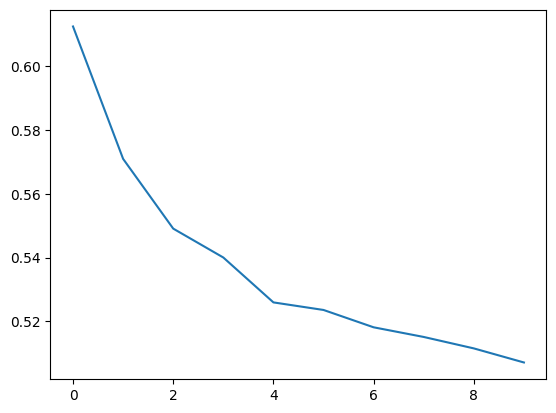

In [6]:
if losses != []: plotter.plot_losses(losses)

# Test Error: 
#  Accuracy: 53.3%, Avg loss: 0.005412 